<a href="https://colab.research.google.com/github/cvs2010/DeepLearningProjects/blob/main/Project_7_forecasting_prices_zapimoveis_df.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto 7: Previsão do preço de imóveis no Distrito Federal
Base de dados: https://github.com/cvs2010/DeepLearningProjects/raw/main/files/dataset-imovel-df-clean-transformed.csv

Data da extração: 01/07/2023

# Etapa 1: Importando bibliotecas

In [5]:
# Importando as bibliotecas
import os
import gdown
import bs4
from bs4 import BeautifulSoup
import urllib.request as urllib_request
from urllib.request import Request, urlopen, urlretrieve
from urllib.request import Request, urlopen
from urllib.error import URLError, HTTPError
import urllib.parse
import pandas as pd
import re
import requests
import math
from numpy.lib.function_base import quantile
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

print("Tensorflow ->", tf.__version__)
print("BeautifulSoup ->", bs4.__version__)
print("urllib ->", urllib_request.__version__)
print("pandas ->", pd.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow -> 2.12.0
BeautifulSoup -> 4.11.2
urllib -> 3.10
pandas -> 1.5.3


#  Etapa 2: Importando o DataFrame

In [3]:
# Download data from https://github.com/
! wget https://github.com/cvs2010/DeepLearningProjects/raw/main/files/dataset-imovel-df-clean-transformed.csv

--2023-07-03 13:05:39--  https://github.com/cvs2010/DeepLearningProjects/raw/main/files/dataset-imovel-df-clean-transformed.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cvs2010/DeepLearningProjects/main/files/dataset-imovel-df-clean-transformed.csv [following]
--2023-07-03 13:05:39--  https://raw.githubusercontent.com/cvs2010/DeepLearningProjects/main/files/dataset-imovel-df-clean-transformed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611199 (597K) [text/plain]
Saving to: ‘dataset-imovel-df-clean-transformed.csv’

dataset-imovel-df-c 100%[===================>] 596.87K  --.-KB/s  

In [9]:
house_df = pd.read_csv('dataset-imovel-df-clean-transformed.csv')
house_df

,valor,quartos,garagem,banheiro,area,suite,academia,varanda,transporte,salao,planejado,latitude,longitude
0,85000,1,0,1,140,0,0,0,1,0,0,-15.847174,-47.914693
1,85000,1,0,1,140,0,0,0,1,0,0,-15.847174,-47.914693
2,85000,1,0,1,140,0,0,0,1,0,0,-15.847174,-47.914693
3,85000,1,0,1,140,0,0,0,1,0,0,-15.847174,-47.914693
4,85000,1,0,1,140,0,0,0,1,0,0,-15.847174,-47.914693
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11266,64999,2,1,1,55,0,0,0,0,0,0,-15.736666,-47.781062
11267,64999,2,1,1,55,0,0,0,0,0,0,-15.736666,-47.781062
11268,64999,2,1,1,55,0,0,0,0,0,0,-15.736666,-47.781062
11269,64999,2,1,1,55,0,0,0,0,0,0,-15.736666,-47.781062


In [10]:
# Organizando os dados pelo valor do imóvel
house_df = house_df.sort_values(by=['valor'])
# Reformulando o index do dataframe
house_df = house_df.reset_index(drop=True)
house_df

,valor,quartos,garagem,banheiro,area,suite,academia,varanda,transporte,salao,planejado,latitude,longitude
0,10000,1,1,1,35,0,0,0,0,0,0,-15.863734,-48.025135
1,10000,1,1,1,35,0,0,0,0,0,0,-15.863734,-48.025135
2,10000,1,1,1,35,0,0,0,0,0,0,-15.863734,-48.025135
3,20000,1,0,1,20,0,0,0,1,0,0,-15.816945,-47.900049
4,20000,1,0,1,20,0,0,0,1,0,0,-15.816945,-47.900049
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11266,820000,3,2,2,83,0,0,0,0,0,0,-15.803258,-47.885477
11267,820000,3,2,2,83,0,0,0,0,0,0,-15.803258,-47.885477
11268,820000,3,2,2,83,0,0,0,0,0,0,-15.803258,-47.885477
11269,820000,3,2,1,83,0,0,0,0,0,0,-15.803258,-47.885477


In [14]:
house_df.head(50)

,valor,quartos,garagem,banheiro,area,suite,academia,varanda,transporte,salao,planejado,latitude,longitude
0,10000,1,1,1,35,0,0,0,0,0,0,-15.863734,-48.025135
1,10000,1,1,1,35,0,0,0,0,0,0,-15.863734,-48.025135
2,10000,1,1,1,35,0,0,0,0,0,0,-15.863734,-48.025135
3,20000,1,0,1,20,0,0,0,1,0,0,-15.816945,-47.900049
4,20000,1,0,1,20,0,0,0,1,0,0,-15.816945,-47.900049
5,20000,1,0,1,20,0,0,0,1,0,0,-15.816945,-47.900049
6,20000,1,0,1,20,0,0,0,1,0,0,-15.816945,-47.900049
7,20000,1,0,1,20,0,0,0,1,0,0,-15.816945,-47.900049
8,25000,1,0,1,200,0,0,0,1,0,0,-15.900596,-47.780384
9,25000,1,0,1,200,0,0,0,1,0,0,-15.904653,-47.770176


In [15]:
house_df.tail(50)

,valor,quartos,garagem,banheiro,area,suite,academia,varanda,transporte,salao,planejado,latitude,longitude
11221,800000,4,5,1,250,1,0,0,1,0,0,-15.828767,-48.097105
11222,800000,3,4,2,200,1,0,0,0,0,1,-15.842272,-48.043684
11223,800000,3,4,2,200,1,0,0,0,0,1,-15.842272,-48.043684
11224,800000,3,2,2,109,1,0,1,0,0,0,-15.803258,-47.885477
11225,800000,3,2,2,109,1,0,1,0,0,0,-15.803258,-47.885477
11226,800000,4,5,1,250,1,0,0,1,0,0,-15.828767,-48.097105
11227,800000,4,5,1,250,1,0,0,1,0,0,-15.828767,-48.097105
11228,800000,3,1,2,78,1,0,1,0,0,0,-15.826680,-47.983382
11229,800000,3,2,2,109,1,0,1,0,0,0,-15.803258,-47.885477
11230,800000,2,6,2,120,0,0,0,0,0,0,-15.794388,-48.049795


In [11]:
# Dataframe com os 11271 linhas e 13 colunas
house_df.shape

(11271, 13)

In [12]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11271 entries, 0 to 11270
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   valor       11271 non-null  int64  
 1   quartos     11271 non-null  int64  
 2   garagem     11271 non-null  int64  
 3   banheiro    11271 non-null  int64  
 4   area        11271 non-null  int64  
 5   suite       11271 non-null  int64  
 6   academia    11271 non-null  int64  
 7   varanda     11271 non-null  int64  
 8   transporte  11271 non-null  int64  
 9   salao       11271 non-null  int64  
 10  planejado   11271 non-null  int64  
 11  latitude    11271 non-null  float64
 12  longitude   11271 non-null  float64
dtypes: float64(2), int64(11)
memory usage: 1.1 MB


In [13]:
house_df.describe()

,valor,quartos,garagem,banheiro,area,suite,academia,varanda,transporte,salao,planejado,latitude,longitude
count,11271.000000,11271.000000,11271.000000,11271.000000,11271.000000,11271.000000,11271.000000,11271.000000,11271.000000,11271.000000,11271.000000,11271.000000,11271.000000
mean,337157.691864,2.379647,1.689557,1.601100,108.722296,0.284447,0.012687,0.052258,0.158460,0.026262,0.051371,-15.828962,-47.985116
std,178484.606862,1.039439,5.815949,0.817214,60.906681,0.451171,0.111927,0.222557,0.365188,0.159921,0.220763,0.085457,0.125049
min,10000.000000,1.000000,0.000000,1.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-16.019399,-48.202189
25%,200000.000000,2.000000,0.000000,1.000000,58.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.871185,-48.075634
50%,310000.000000,2.000000,1.000000,1.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.828767,-48.017476
75%,450000.000000,3.000000,2.000000,2.000000,150.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.803258,-47.900049
max,820000.000000,15.000000,300.000000,7.000000,285.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-15.506479,-47.597110


#  Etapa 3: Visualizando os dados

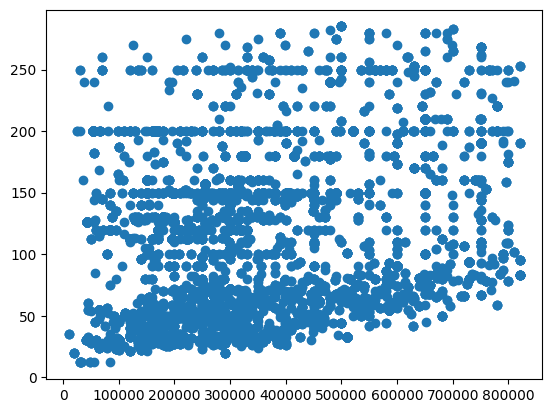

In [17]:
plt.scatter(house_df['valor'], house_df['area']);

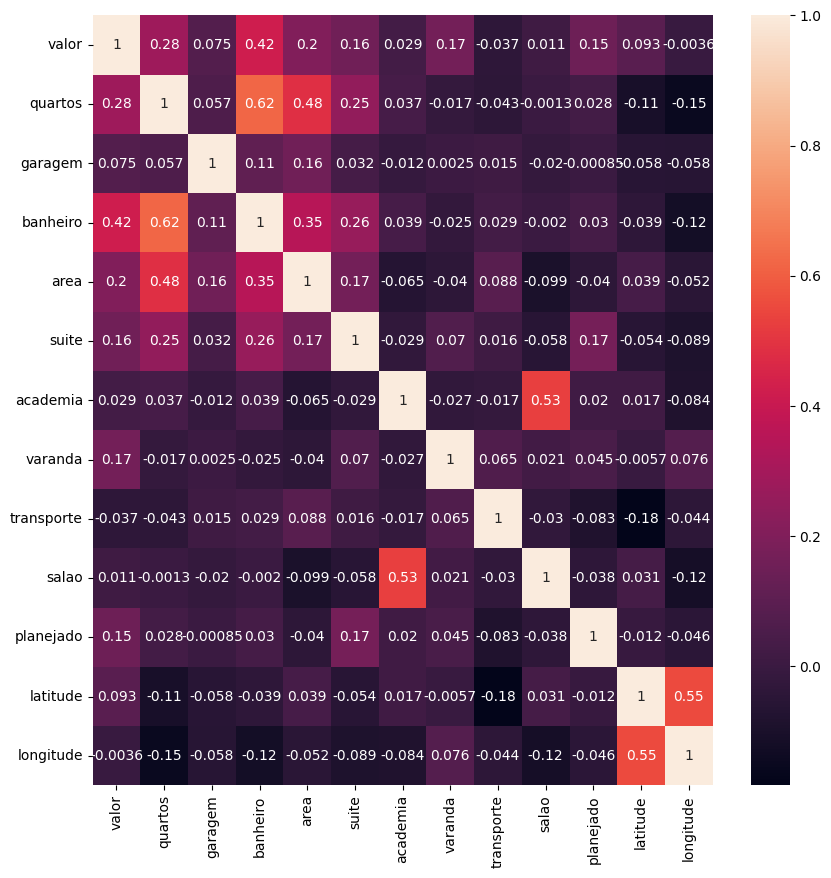

In [19]:
f, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(house_df.corr(), annot = True);

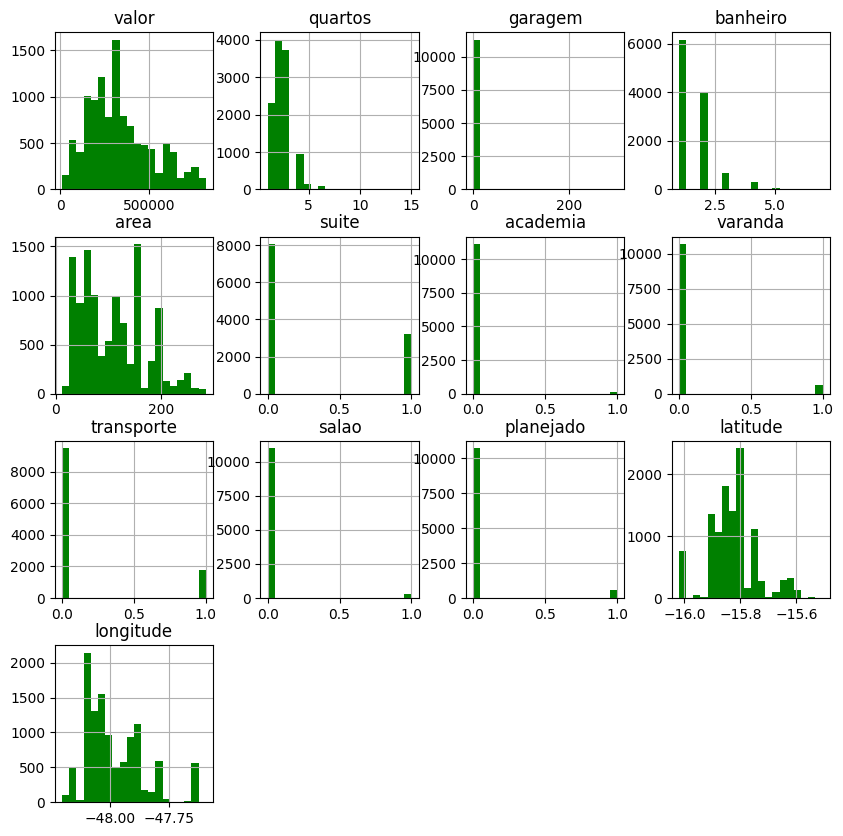

In [21]:
house_df.hist(bins = 20, figsize = (10,10), color = 'g');

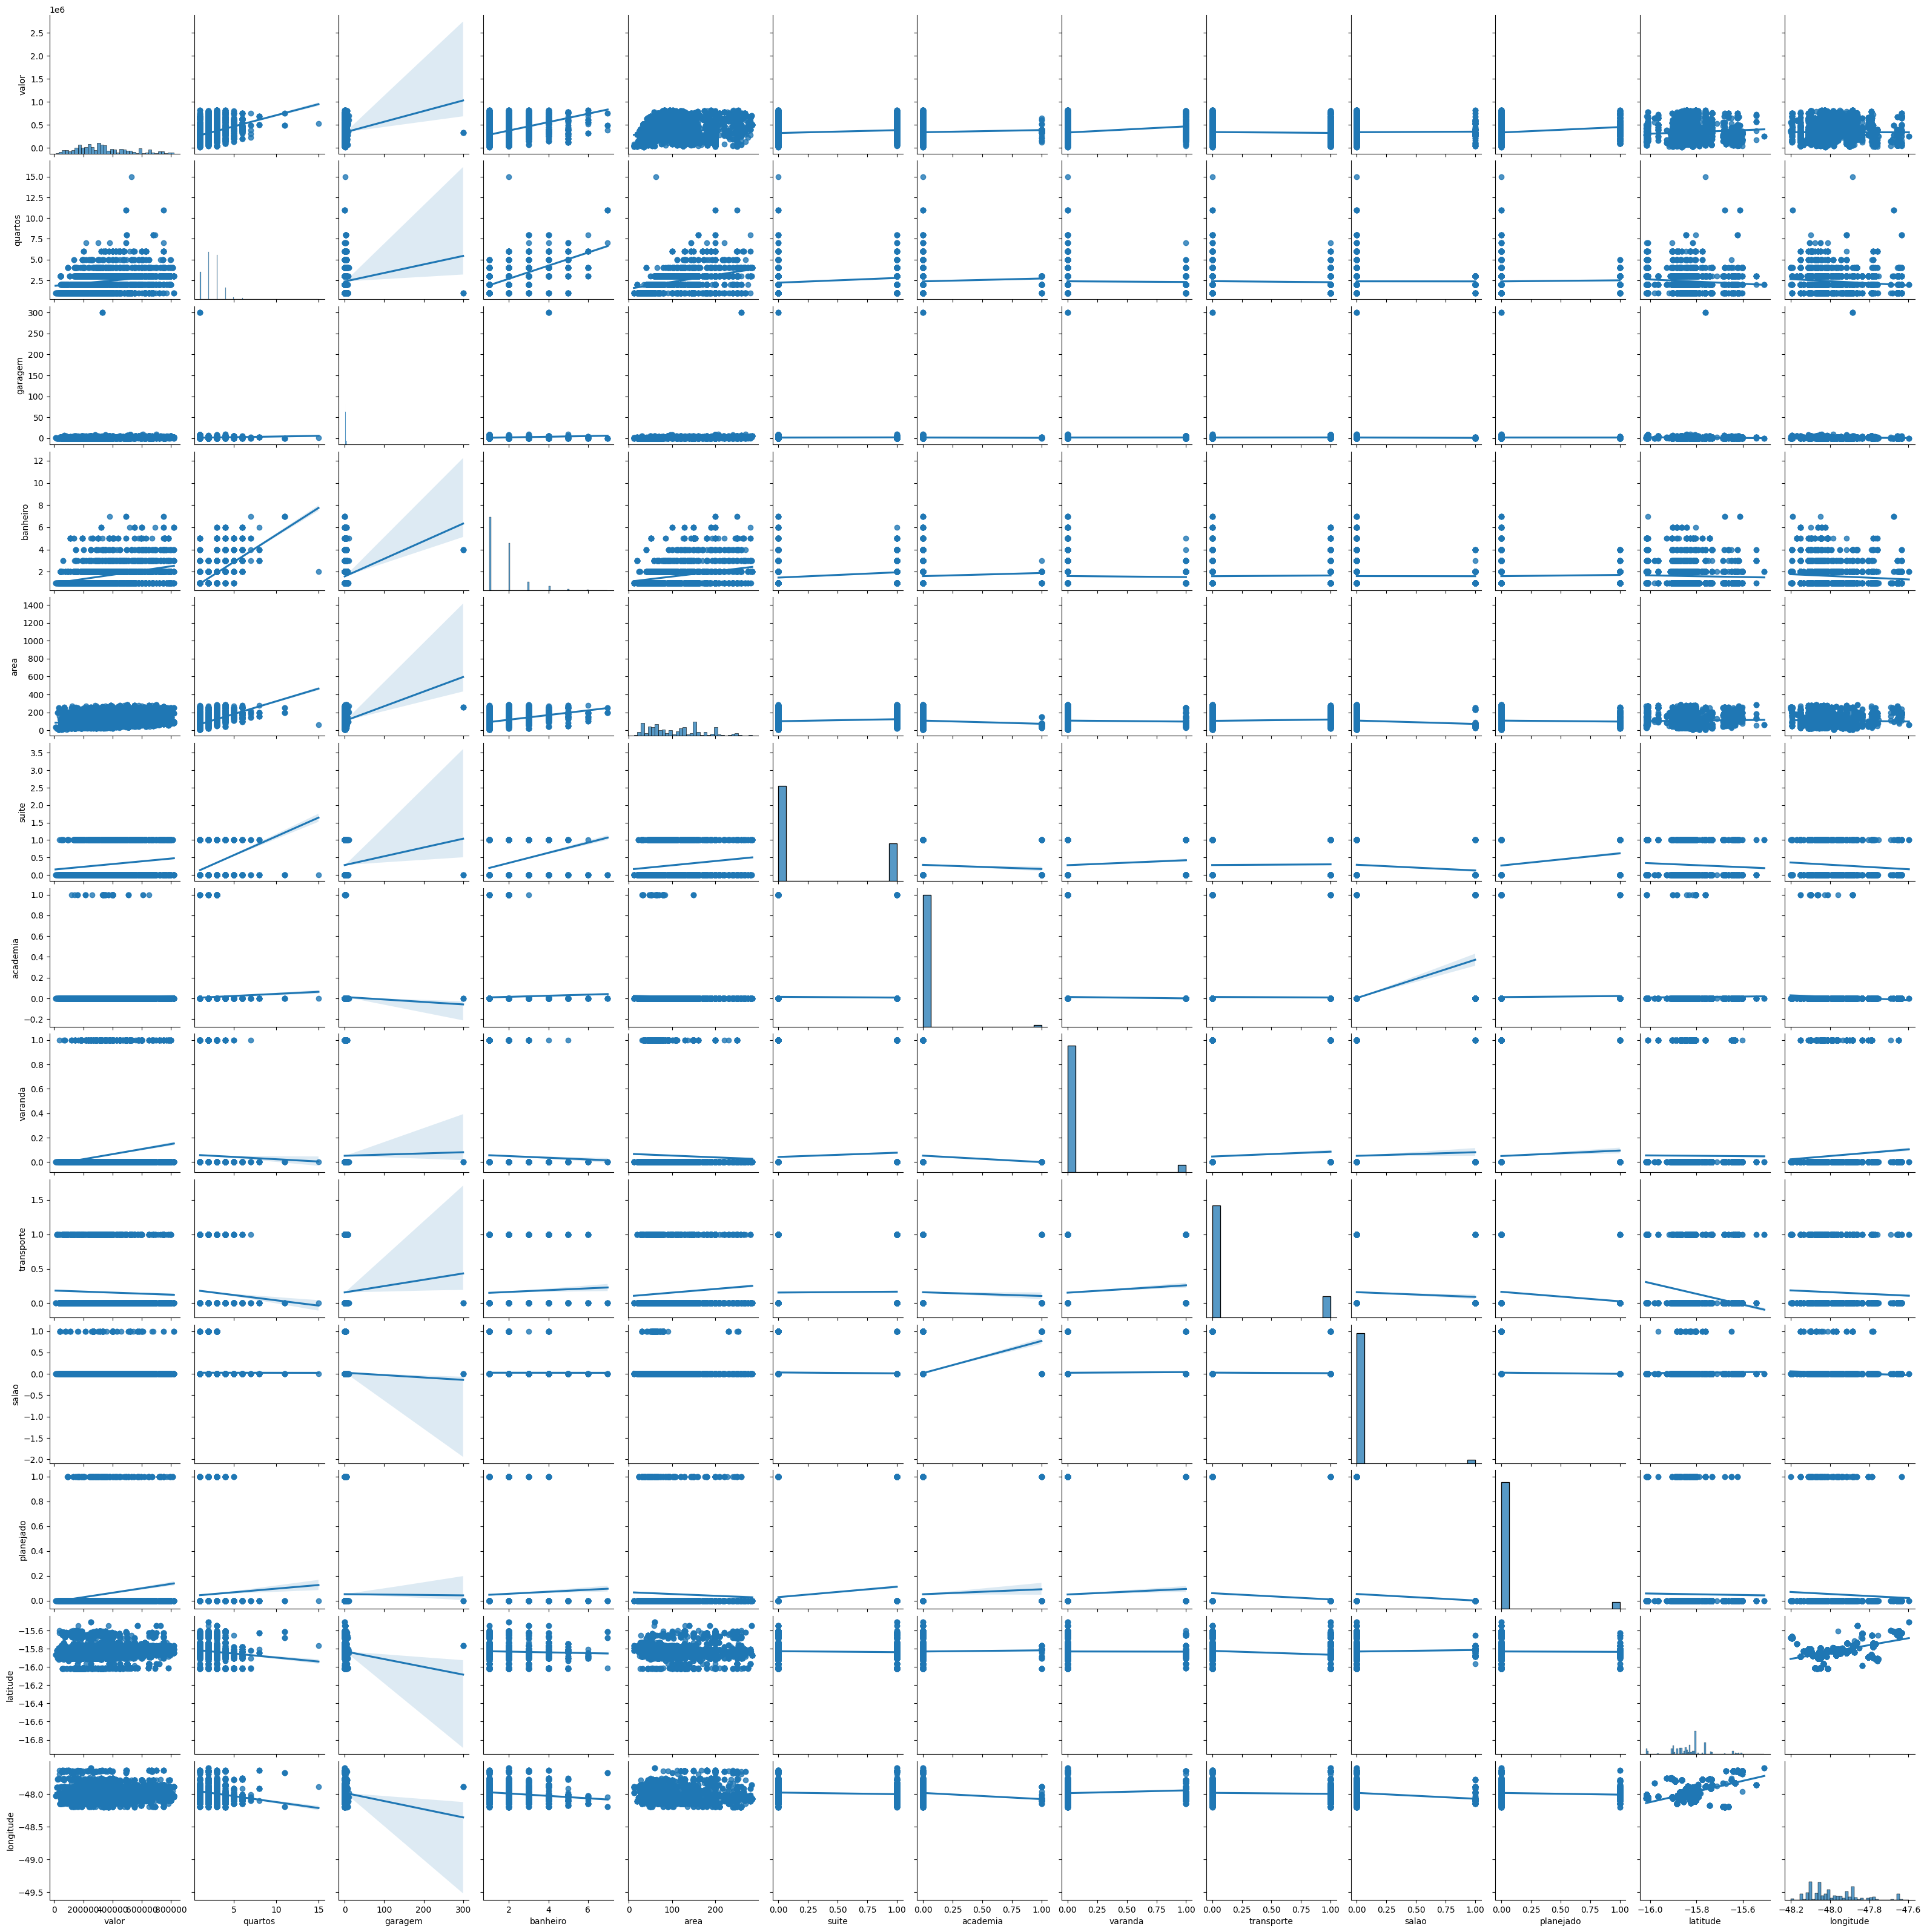

In [23]:
sns.pairplot(kind='reg', data=house_df);

# Etapa 4: Tratamento do dataset para previsão

In [24]:
selected_features = ['quartos', 'garagem', 'banheiro','area', 'suite', 'academia', 'varanda', 'transporte', 'salao', 'planejado', 'latitude', 'longitude']

In [25]:
X = house_df[selected_features]

In [26]:
y = house_df['valor']

In [27]:
X.head()

,quartos,garagem,banheiro,area,suite,academia,varanda,transporte,salao,planejado,latitude,longitude
0,1,1,1,35,0,0,0,0,0,0,-15.863734,-48.025135
1,1,1,1,35,0,0,0,0,0,0,-15.863734,-48.025135
2,1,1,1,35,0,0,0,0,0,0,-15.863734,-48.025135
3,1,0,1,20,0,0,0,1,0,0,-15.816945,-47.900049
4,1,0,1,20,0,0,0,1,0,0,-15.816945,-47.900049


In [28]:
y.head()

0    10000
1    10000
2    10000
3    20000
4    20000
Name: valor, dtype: int64

In [29]:
X.shape

(11271, 12)

In [30]:
y.shape

(11271,)

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [32]:
X_scaled

array([[0.        , 0.00333333, 0.        , ..., 0.        , 0.30348802,
        0.29261309],
       [0.        , 0.00333333, 0.        , ..., 0.        , 0.30348802,
        0.29261309],
       [0.        , 0.00333333, 0.        , ..., 0.        , 0.30348802,
        0.29261309],
       ...,
       [0.14285714, 0.00666667, 0.16666667, ..., 0.        , 0.4213926 ,
        0.52342256],
       [0.14285714, 0.00666667, 0.        , ..., 0.        , 0.4213926 ,
        0.52342256],
       [0.14285714, 0.00666667, 0.16666667, ..., 0.        , 0.4213926 ,
        0.52342256]])

In [33]:
X_scaled.shape

(11271, 12)

In [34]:
scaler.data_max_

array([ 15.       , 300.       ,   7.       , 285.       ,   1.       ,
         1.       ,   1.       ,   1.       ,   1.       ,   1.       ,
       -15.5064787, -47.5971095])

In [35]:
scaler.data_min_

array([  1.        ,   0.        ,   1.        ,  12.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        , -16.01939895, -48.20218898])

In [42]:
# transformação dos dados de y em float
y = y.astype('float')
y

0         10000.0
1         10000.0
2         10000.0
3         20000.0
4         20000.0
           ...   
11266    820000.0
11267    820000.0
11268    820000.0
11269    820000.0
11270    820000.0
Name: valor, Length: 11271, dtype: float64

In [52]:
y = y.to_numpy()

In [53]:
y = y.reshape(-1, 1)

In [54]:
y_scaled = scaler.fit_transform(y)

In [55]:
y_scaled

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.25)

In [57]:
X_train.shape

(8453, 12)

In [58]:
X_test.shape

(2818, 12)

# Etapa 5: Construção e criação do modelo

In [64]:
# Construção do modelo sequencial
model = tf.keras.models.Sequential()  # Criando sequencia de camadas
model.add(tf.keras.layers.Dense(units=100, activation='relu', input_shape=(12, ))) # units = 100 neurônios na camada oculta; input_shape = 12 neurônios de entrada
                                                                                  # Porque temos 12 atributos previsores (X_train_shape = 12)
model.add(tf.keras.layers.Dense(units=100, activation='relu'))  # units = 100 neurônios na camada oculta;
model.add(tf.keras.layers.Dense(units=100, activation='relu'))  # units = 100 neurônios na camada oculta;
model.add(tf.keras.layers.Dense(units=1, activation='linear'))  # input_shape = 1 neurônios de saída linear, a resposta que queremos (preço)

In [65]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               1300      
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 21,601
Trainable params: 21,601
Non-trainable params: 0
_________________________________________________________________


In [66]:
model.compile(optimizer='Adam', loss='mean_squared_error')

## Treinamento do modelo
A quantidade total de dados de X é 11271. A quantidade separada para treinamento (X_train) foi 8453 Aqui iremos segregar 20% (0.2) para validação e 80% (0.8) para teste. X_test será aproximadamente 2818. X_val será aproximadamente 3.241

Dessa maneira, o batch de 50 produzirá (11271/50 = 225,42) 226 instâncias em cada treino.

O número de épocas (treinos) será de 100. Selecionamos na célula anterior o otimizados 'Adam' e a função de perda 'mean_squared_error'.

In [67]:
epochs_hist = model.fit(X_train, y_train, epochs = 100, batch_size = 50, validation_split = 0.2)

Epoch 1/100
136/136 [==============================] - 2s 4ms/step - loss: 0.0418 - val_loss: 0.0304
Epoch 2/100
136/136 [==============================] - 0s 3ms/step - loss: 0.0263 - val_loss: 0.0241
Epoch 3/100
136/136 [==============================] - 0s 3ms/step - loss: 0.0216 - val_loss: 0.0212
Epoch 4/100
136/136 [==============================] - 0s 2ms/step - loss: 0.0195 - val_loss: 0.0179
Epoch 5/100
136/136 [==============================] - 0s 3ms/step - loss: 0.0179 - val_loss: 0.0240
Epoch 6/100
136/136 [==============================] - 1s 7ms/step - loss: 0.0169 - val_loss: 0.0154
Epoch 7/100
136/136 [==============================] - 1s 4ms/step - loss: 0.0153 - val_loss: 0.0168
Epoch 8/100
136/136 [==============================] - 1s 6ms/step - loss: 0.0146 - val_loss: 0.0151
Epoch 9/100
136/136 [==============================] - 1s 5ms/step - loss: 0.0139 - val_loss: 0.0134
Epoch 10/100
136/136 [==============================] - 0s 3ms/step - loss: 0.0133 - val_lo

# Etapa 6: Avaliação do modelo

In [68]:
epochs_hist.history.keys()

dict_keys(['loss', 'val_loss'])

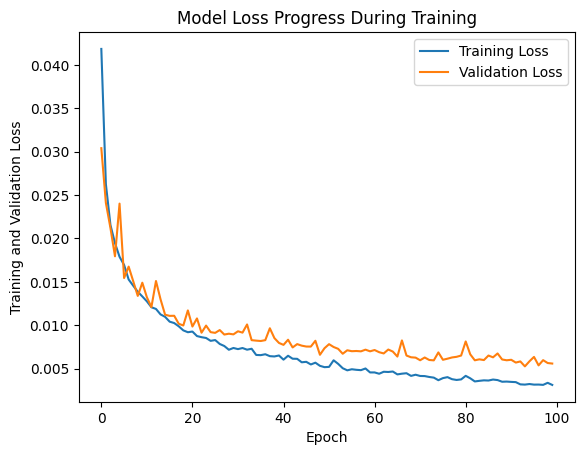

In [69]:
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])
plt.title('Model Loss Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Loss')
plt.legend(['Training Loss', 'Validation Loss']);

89/89 [==============================] - 0s 2ms/step


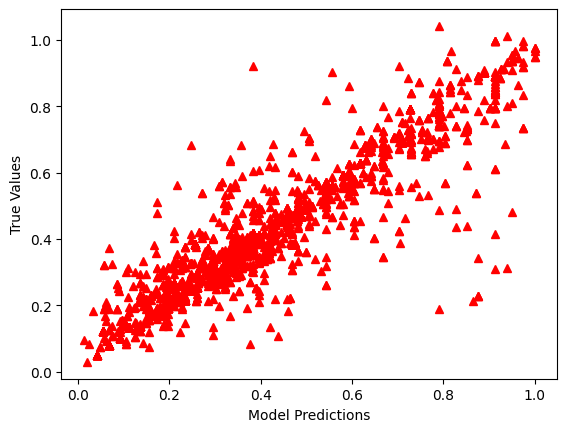

In [70]:
y_predict = model.predict(X_test)
plt.plot(y_test, y_predict, "^", color = 'r')
plt.xlabel('Model Predictions')
plt.ylabel('True Values');

In [73]:
k = X_test.shape[1]
n = len(X_test)
n

2818

In [74]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

RMSE = float(format(np.sqrt(mean_squared_error(y_test, y_predict)),'.3f'))
MSE = mean_squared_error(y_test, y_predict)
MAE = mean_absolute_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict) # O ideal é o R2 ser próximo de 1.0 e maior que o R2 ajustado
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2)

RMSE = 0.077 
MSE = 0.005918650912665068 
MAE = 0.04256196665161558 
R2 = 0.8806445230662884 
Adjusted R2 = 0.8801339114002618


# Etapa 7: Aplicação do modelo

Fazendo uma predição com as selected_features = ['quartos' = 2, 'garagem' = 0, 'banheiro' = 2, 'area' = 100, 'suite' = 1, 'academia' = 0, 'varanda' = 1, 'transporte' = 0, 'salao' = 0, 'planejado' = 0, 'latitude' = -15.847174	, 'longitude' = -47.914693]


In [75]:
# 'bedrooms','bathrooms','sqft_living','sqft_lot','floors', 'sqft_above', 'sqft_basement'
X_test_1 = np.array([[ 3, 0, 2, 100, 1, 0, 1, 0, 0, 0, -15.847174, -47.914693 ]])

scaler_1 = MinMaxScaler()
X_test_scaled_1 = scaler_1.fit_transform(X_test_1)

y_predict_1 = model.predict(X_test_scaled_1)

y_predict_1 = scaler.inverse_transform(y_predict_1)
y_predict_1

1/1 [==============================] - 0s 21ms/step


array([[351896.3]], dtype=float32)